In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sp
import OGRePy as gr

**OGRePy: An <u>O</u>bject-Oriented <u>G</u>eneral <u>Re</u>lativity Package for <u>Py</u>thon\
By [Barak Shoshany](https://github.com/bshoshany) ([baraksh@gmail.com](mailto:baraksh@gmail.com)) ([baraksh.com](https://baraksh.com/))\
v1.2.0 (2024-09-15)\
GitHub repository: <https://github.com/bshoshany/OGRePy>\
Documentation: <a href="c:/Users/suzan/AppData/Local/Programs/Python/Python312/Lib/site-packages/OGRePy/docs/OGRePy_Documentation.ipynb">.ipynb</a>, <a href="c:/Users/suzan/AppData/Local/Programs/Python/Python312/Lib/site-packages/OGRePy/docs/OGRePy_Documentation.pdf">.pdf</a>, <a href="#" onclick="window.open('file:///c:/Users/suzan/AppData/Local/Programs/Python/Python312/Lib/site-packages/OGRePy/docs/OGRePy_Documentation.html', '_blank')">.html</a>**

**OGRePy**: You have the latest version of the package.

In [5]:
# represent the SC metric symbolically

import sympy as sp

def build_metric():
    # Define symbolic variables for t, r, theta, phi
    t, r, theta, phi = sp.symbols('t r theta phi')
    
    # Define metric functions symbolically
    f = sp.Function('f')(r)
    g = sp.Function('g')(r)
    h = sp.Function('h')(r)
    
    # Build the Schwarzschild metric tensor
    metric = sp.Matrix([
        [-f, 0, 0, 0],                     
        [0, g, 0, 0],                     
        [0, 0, h, 0],                      
        [0, 0, 0, h * sp.sin(theta)**2]   
    ])
    
    return metric, (t, r, theta, phi)

# Build the symbolic metric
metric_sym, coords = build_metric()

# Print the metric tensor
print("Symbolic Metric Tensor:")
sp.pprint(metric_sym)
print(coords)




Symbolic Metric Tensor:
⎡-f(r)   0     0         0      ⎤
⎢                               ⎥
⎢  0    g(r)   0         0      ⎥
⎢                               ⎥
⎢  0     0    h(r)       0      ⎥
⎢                               ⎥
⎢                           2   ⎥
⎣  0     0     0    h(r)⋅sin (θ)⎦
(t, r, theta, phi)


In [3]:
# constants
c = 1.0 # speed of light (normalized)
G = 1.0 # gravitational constant (normalized)

# function to get schwarzschild radius from mass
def rad_sc(M):
    return (2*G*M/c**2)

# schwarzschild functions (dependent on radial component, r, and Schwarzschild radius)
def f(r, M):
    return 1 - (2*G*M/(c**2*r))

def g(r, M):
    return (1 - 2*G*M/(c**2*r))**(-1)

def h(r):
    return r**2

In [17]:
# functions to calculate effective potential (v_eff) & equations of motion for a Schwarzschild spacetime

# effective potential
def v_eff(r, M, L, sigma=0):
    return -(f(r, M) * (sigma - (L**2 * h(r)**(-1))))

# equations of motion
def eq_of_motion(tau, y, params, sigma=0):

    t, r, phi = y
    E, L, M = params

    dt_dtau = E / f(r, M)
    dphi_dtau = L / h(r)
    dr_dtau = np.sqrt(g(r, M)**(-1) * (f(r, M)**(-1) * E**2 + (sigma - L**2 / h(r))))

    return [dt_dtau, dr_dtau, dphi_dtau]

In [18]:
# assign values for parameters
M1 = 1.0  
rs1 = rad_sc(M1)
r1 = 10 * rs1  # set particle radius as SC radius times 10

# conserved quantities
E1 = 1.0 # energy of orbiting particle
L1 = 3.0 # angular momentum of orbiting particle
L2 = 3.05
L3 = 3.1

# calculate and print SC metric components for the given r, M
f1 = f(r1, M1)
g1 = g(r1, M1)
h1 = h(r1)

print(f"f(r) = {f1}")
print(f"g(r) = {g1}")
print(f"h(r) = {h1}")

f(r) = 0.9
g(r) = 1.1111111111111112
h(r) = 400.0


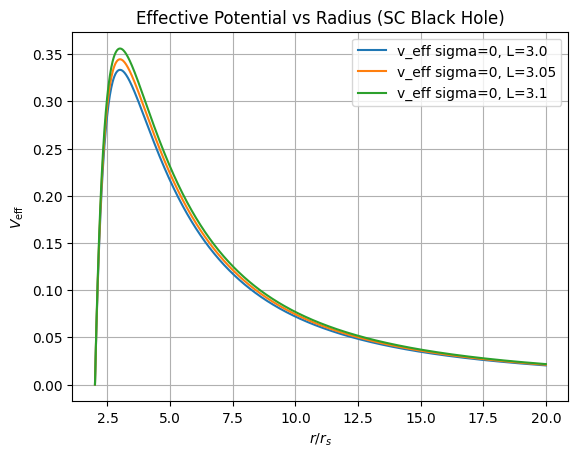

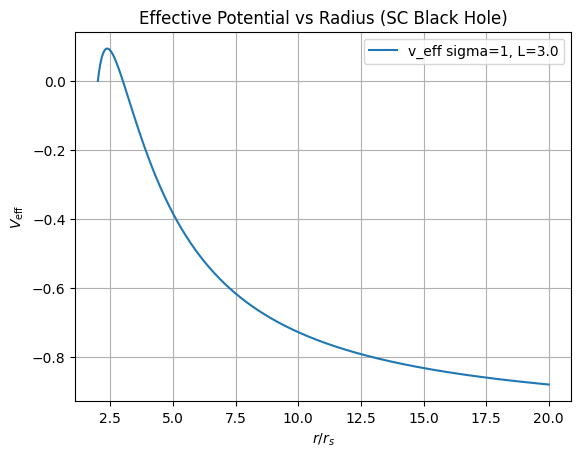

In [19]:
# calculate v_eff as a function of r with given M, L
# evenly spaced values of r (r/r_s) as the x axis
r_vals = np.linspace(rs1, r1, 1000)

# get list of effective potential values for sigma=0
v_eff_vals = np.array([v_eff(i, M1, L1, sigma=0) for i in r_vals])
v_eff_vals_L2 = np.array([v_eff(i, M1, L2, sigma=0) for i in r_vals])
v_eff_vals_L3 = np.array([v_eff(i, M1, L3, sigma=0) for i in r_vals])

# get list of effective potential values for sigma=1
v_eff_vals1 = np.array([v_eff(i, M1, L1, sigma=1) for i in r_vals])

# Plot the results sigma = 0
plt.plot(r_vals, v_eff_vals, label=f'v_eff sigma=0, L={L1}')
plt.plot(r_vals, v_eff_vals_L2, label=f'v_eff sigma=0, L={L2}')
plt.plot(r_vals, v_eff_vals_L3, label=f'v_eff sigma=0, L={L3}')
plt.xlabel(r'$r / r_s$')
plt.ylabel(r'$V_{\rm eff}$')
plt.title('Effective Potential vs Radius (SC Black Hole)')
plt.legend()
plt.grid(True)
plt.show()
# Plot the results sigma = 1
plt.plot(r_vals, v_eff_vals1, label=f'v_eff sigma=1, L={L1}')
plt.xlabel(r'$r / r_s$')
plt.ylabel(r'$V_{\rm eff}$')
plt.title('Effective Potential vs Radius (SC Black Hole)')
plt.legend()
plt.grid(True)
plt.show()


EXTREMA and LIMITS

Null Geodesics - sigma = 0
As r --> infinity
v_eff --> (1 - 0) * (0 - 0) = 0 i.e. approaches 0 asymptotically

Time-like Geodesics - sigma = 1
As r --> infinity
v_eff --> (1 - 0) * (1 - 0) = 1 i.e. approaches -1 asymptotically

Extrema for sigma=0:
r = 3.0090, V_eff = 0.3333

Extrema for sigma=1:
r = 2.3784, V_eff = 0.0940


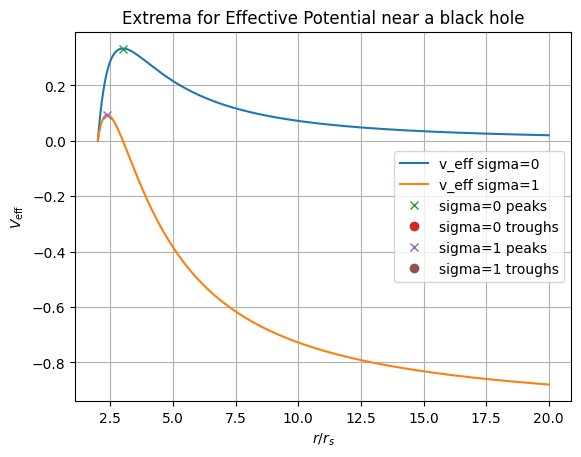

In [20]:
# find extrema for effective potential for space around a Schwarzschild black hole
from scipy.signal import find_peaks

# find peaks for sigma=0, sigma=1
peaks1, _ = find_peaks(v_eff_vals)
peaks2, _ = find_peaks(v_eff_vals1)

# detect troughs (invert the function to find minima as peaks) for sigma=0, sigma=1
troughs1, _ = find_peaks(-v_eff_vals)
troughs2, _ = find_peaks(-v_eff_vals1)

# combine and sort extrema
extrema1 = np.sort(np.concatenate((peaks1, troughs1)))
extrema2 = np.sort(np.concatenate((peaks2, troughs2)))

# print extrema values for sigma=0 and sigma=1
print("Extrema for sigma=0:")
for j in extrema1:
    print(f"r = {r_vals[j]:.4f}, V_eff = {v_eff_vals[j]:.4f}")

print("\nExtrema for sigma=1:")
for k in extrema2:
    print(f"r = {r_vals[k]:.4f}, V_eff = {v_eff_vals1[k]:.4f}")

plt.plot(r_vals, v_eff_vals, label='v_eff sigma=0')
plt.plot(r_vals, v_eff_vals1, label='v_eff sigma=1')
plt.plot(r_vals[peaks1], v_eff_vals[peaks1], 'x', label='sigma=0 peaks')
plt.plot(r_vals[troughs1], v_eff_vals[troughs1], 'o', label='sigma=0 troughs')
plt.plot(r_vals[peaks2], v_eff_vals1[peaks2], 'x', label='sigma=1 peaks')
plt.plot(r_vals[troughs2], v_eff_vals1[troughs2], 'o', label='sigma=1 troughs')
plt.xlabel(r'$r / r_s$')
plt.ylabel(r'$V_{\rm eff}$')
plt.title('Extrema for Effective Potential near a black hole')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# solvers to compute r(phi) and r(t), phi(t)
# solve for r(phi) or phi(r)
def solve_r_phi(params, phi_range, r_init, sigma=0):
    def dr_dphi(tau, y):
        return eq_of_motion(tau, y, params, sigma)

    # initial conditions [t, r, phi]
    y0 = [0, r_init, phi_range[0]]

    sol = solve_ivp(
        dr_dphi, phi_range, y0, t_eval=np.linspace(*phi_range, 1000), dense_output=True
    )
    return sol

# Solve for r(t) and phi(t)
def solve_r_t(params, tau_range, r_init, phi_init, sigma=0):
    def dydtau(tau, y):
        return eq_of_motion(tau, y, params, sigma)

    # initial conditions [t, r, phi]
    y0 = [0, r_init, phi_init]

    sol = solve_ivp(
        dydtau, tau_range, y0, t_eval=np.linspace(*tau_range, 1000), dense_output=True
    )
    return sol


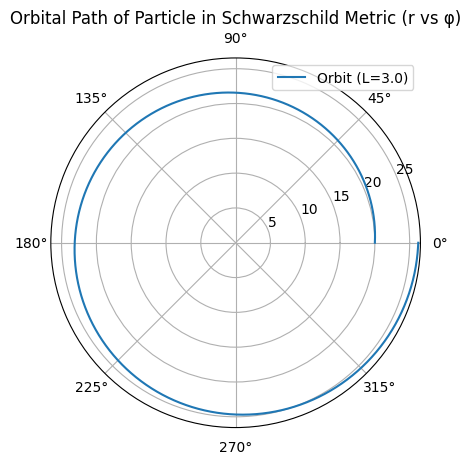

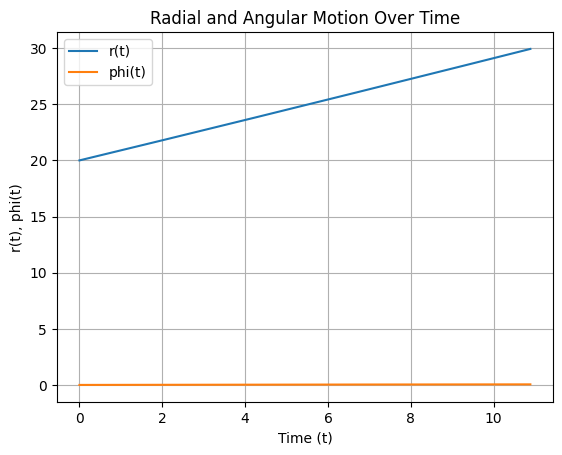

In [22]:
# set parameters
r0 = 10 * rs1  # starting radius
params = [E1, L1, M1]

# find dphi/dr and solve for r(phi)
phi_range = [0, 2 * np.pi]
r_phi_sol = solve_r_phi(params, phi_range, r0, sigma=0)
phi_vals = r_phi_sol.t
r_vals_orbit = r_phi_sol.y[1]

# polar plot of r(phi)
plt.polar(phi_vals, r_vals_orbit, label=f'Orbit (L={L1})')
plt.title('Orbital Path of Particle in Schwarzschild Metric (r vs φ)')
plt.legend()
plt.grid(True)
plt.show()

# solve for r(t) and phi(t)
tau_range = [0, 10] # absolute time range
phi_init = 0
r_t_sol = solve_r_t(params, tau_range, r0, phi_init, sigma=0)
t_vals = r_t_sol.y[0]
r_vals_t = r_t_sol.y[1]
phi_vals_t = r_t_sol.y[2]

# parametric plot of r(t) and phi(t)
plt.plot(t_vals, r_vals_t, label='r(t)')
plt.plot(t_vals, phi_vals_t, label='phi(t)')
plt.xlabel('Time (t)')
plt.ylabel('r(t), phi(t)')
plt.title('Radial and Angular Motion Over Time')
plt.legend()
plt.grid(True)
plt.show()